In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt


RANDOM_SEED = 42

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
#Data HDP for different number of components
N_settings = 3
n = 1000  # Total number of samples
N_components = [2, 3, 4]  # Number of components for each setting
N_sources = 2  # Number of sources
ks = [2, 3, 4]  # Number of components in model for each setting
sigma = 0.01  # Standard deviation for the noise
a1 = [0, 10]   # intercepts
b1 = [5, 10]  # slopes
a2 = [0, 10, -10]   # intercepts
b2 = [5, 10, 20]  # slopes
a3 = [0, 10, -10, 20]   # intercepts
b3 = [5, 10, 20, -5]  # slopes

proportions11 = [0.4, 0.6]  # Proportions for the first dataset
proportions12 = [0.7, 0.3]  # Proportions for the second dataset
proportions21 = [0.4, 0.3, 0.3]  # Proportions for the third dataset
proportions22 = [0.7, 0.2, 0.1]  # Proportions for the fourth dataset
proportions31 = [0.3, 0.2, 0.4, 0.1]  # Proportions for the fifth dataset
proportions32 = [0.7, 0.1, 0.1, 0.1]  # Proportions for the sixth dataset
proportions1 = [proportions11, proportions21, proportions31]
proportions2 = [proportions12, proportions22, proportions32]
proportions = []



for i in range(N_settings):
    proportions.append([proportions1[i], proportions2[i]])

a = [a1, a2, a3]
b = [b1, b2, b3]

X = []
Y = []

def Generate_dataset_HDP(n, N_sources, N_components, b, a, sigma, proportions):
    # Initialize lists to store data
    X = []
    Y = []

    # Generate data for each source
    for j in range(N_sources):
        X_source = []
        Y_source = []
        proportion = proportions[j]
        for i in range(N_components):
            size_i = int(n * proportion[i])
            X_component = np.random.uniform(-10 + 20 * i, 10 + 20 * i, size=(size_i, 1))
            e_component = np.random.normal(0, sigma, size=(size_i, 1))
            Y_component = b[i] * X_component + a[i] + e_component

            X_source.append(X_component)
            Y_source.append(Y_component)

        # Store combined data for the source
        X.append(np.vstack(X_source))
        Y.append(np.vstack(Y_source).ravel())
    return X, Y

X = []
Y = []

for i in range(N_settings):
    X_setting, Y_setting = Generate_dataset_HDP(n, N_sources, N_components[i], b[i], a[i], sigma, proportions[i])
    X.append(X_setting)
    Y.append(Y_setting)

In [5]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

def reparameterize(pi):
    return pi / pi.sum()

def hierarchical_beta(alpha0, beta, nsources, k):
    """Hierarchical Beta distribution for multiple sources."""
    pi_tilt_sources = []
    
    for s in range(nsources):
        beta_params = [(alpha0 * beta[k], alpha0 * (1 - pm.math.sum(beta[:k + 1]))) for k in range(k)]
        pi_tilt = pm.Beta(f'pi_tilt_{s}', 
                          alpha=[b[0] for b in beta_params], 
                          beta=[b[1] for b in beta_params], 
                          dims="component")
        pi_tilt_sources.append(pi_tilt)
    
    #return pm.math.stack(pi_tilt_sources, axis=0)
    return pi_tilt_sources

models = []
traces = []

for i in range(N_settings):
    print(f"Running model for setting {i + 1}, total settings: {N_settings}")
    model_name = f"HDP_model_{i + 1}"
    with pm.Model(coords={"component": np.arange(ks[i]),"n_source":np.arange(N_sources)}) as locals()[model_name]:
        # Priors for weight parameter
        gamma = pm.Gamma("gamma", 1.0, 5.0)
        alpha0 = pm.Gamma("alpha0", 1.0, 5.0)
        beta_tilt = pm.Beta("beta_tilt", 1.0, gamma, dims="component") # Generate beta values
        beta = pm.Deterministic("beta", stick_breaking(beta_tilt), dims="component")  
        π_tilt = hierarchical_beta(alpha0, beta, nsources=N_sources, k=ks[i]) # Component weights
        π_norms = list()
        for s in range(N_sources):
            π = pm.Deterministic(f"π_{s}", stick_breaking(π_tilt[s]), dims="component")
            π_norms.append(pm.Deterministic(f"π_norm_{s}", reparameterize(π), dims=["component"])) 
        #π = pm.Deterministic("π", stick_breaking(π_tilt), dims="component")
        #π_norm = pm.Deterministic("π_norm", reparameterize(π), dims=["component"])  # Component weights
        
        
        # Priors for unknown model parameters
        α = pm.Normal('α', mu=0, sigma=100, shape=(1, ks[i])) #Intercept
        β = pm.Normal('β', mu=0, sigma=100, shape=(1, ks[i]))
        σ  = pm.HalfCauchy('σ', 1, shape=ks[i])  #Noise
        
        likelihood = []
        for s in range(N_sources):
            mu = α + β*X[i][s]
            likelihood.append(pm.NormalMixture(f'likelihood_{s}', π_norms[s], mu, sigma=σ, observed=Y[i][s]))
        #mixture_means = β* X[0] + α
        #y_obs_i = pm.NormalMixture(f'likelihood_{0}', π_norm , mixture_means, sigma=σ, observed=Y[0])
        
        trace = pm.sample(
                tune=3000,
                init="advi",
                target_accept=0.975,
                random_seed=RANDOM_SEED,
            )
        
    models.append(locals()[model_name])
    traces.append(trace)

Running model for setting 1, total settings: 3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 90200
Interrupted at 90,199 [45%]: Average Loss = 5.7362e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, alpha0, beta_tilt, pi_tilt_0, pi_tilt_1, α, β, σ]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 734 seconds.
There were 314 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running model for setting 2, total settings: 3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 38800
Interrupted at 38,799 [19%]: Average Loss = 6.2155e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, alpha0, beta_tilt, pi_tilt_0, pi_tilt_1, α, β, σ]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 3288 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running model for setting 3, total settings: 3


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 34500
Interrupted at 34,499 [17%]: Average Loss = 6.1155e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, alpha0, beta_tilt, pi_tilt_0, pi_tilt_1, α, β, σ]


Output()

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 3770 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
def summary_HDP(trace, model, N_sources=1, k=1):
    '''      
    :param trace: trace of the model
    :param model: model
    :param N_sources: number of sources
    :param k: number of components for the model
    :return: 
    '''
    var_names = ["α", "β", "σ", "gamma", "alpha0", "beta"]
    # Add π_norm for each source
    for s in range(N_sources):
        var_names.append(f"π_{s}")
        var_names.append(f"π_norm_{s}")
    print(az.summary(trace, var_names=var_names))
    
    print("Trace summary completed.")
    az.plot_trace(trace, var_names=["α", "β", "σ", "gamma", "alpha0", "beta"])

    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
        
    az.plot_posterior(trace, var_names=["α", "β", "σ", "gamma", "alpha0", "beta"])
    az.plot_ppc(posterior_predictive, num_pp_samples=1000)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_w = np.arange(k) + 1
    for s in range(N_sources):
        ax.bar(
            plot_w - 0.5 + s * 0.1,  # Slight offset for each source
            trace.posterior[f"π_norm_{s}"].mean(("chain", "draw")),
            width=0.1, label=f"Source {s + 1}",
        )
    
    ax.set_xlim(0.5, k)
    ax.set_xlabel("Component")
    ax.set_ylabel("Posterior expected mixture weight")
    ax.legend(title="Sources")
    plt.show()


Running model for setting 1, total settings: 3
True proportion: [[0.4, 0.6], [0.7, 0.3]]
True regression parameters: [0, 10], [5, 10]
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]       0.001  0.000   0.000    0.001      0.000    0.000    5301.0   
α[0, 1]      10.001  0.001   9.998   10.003      0.000    0.000    5556.0   
β[0, 0]       5.000  0.000   5.000    5.000      0.000    0.000    5658.0   
β[0, 1]      10.000  0.000  10.000   10.000      0.000    0.000    5236.0   
σ[0]          0.010  0.000   0.009    0.010      0.000    0.000    4493.0   
σ[1]          0.010  0.000   0.010    0.011      0.000    0.000    6314.0   
gamma         0.431  0.262   0.031    0.908      0.005    0.003    2383.0   
alpha0        0.611  0.314   0.124    1.198      0.009    0.007     869.0   
beta[0]       0.463  0.179   0.130    0.788      0.007    0.005     685.0   
beta[1]       0.353  0.164   0.071    0.658      0.003    0.003    2492.0   
π_0[0]        0.304

Sampling: [likelihood_0, likelihood_1]


Output()

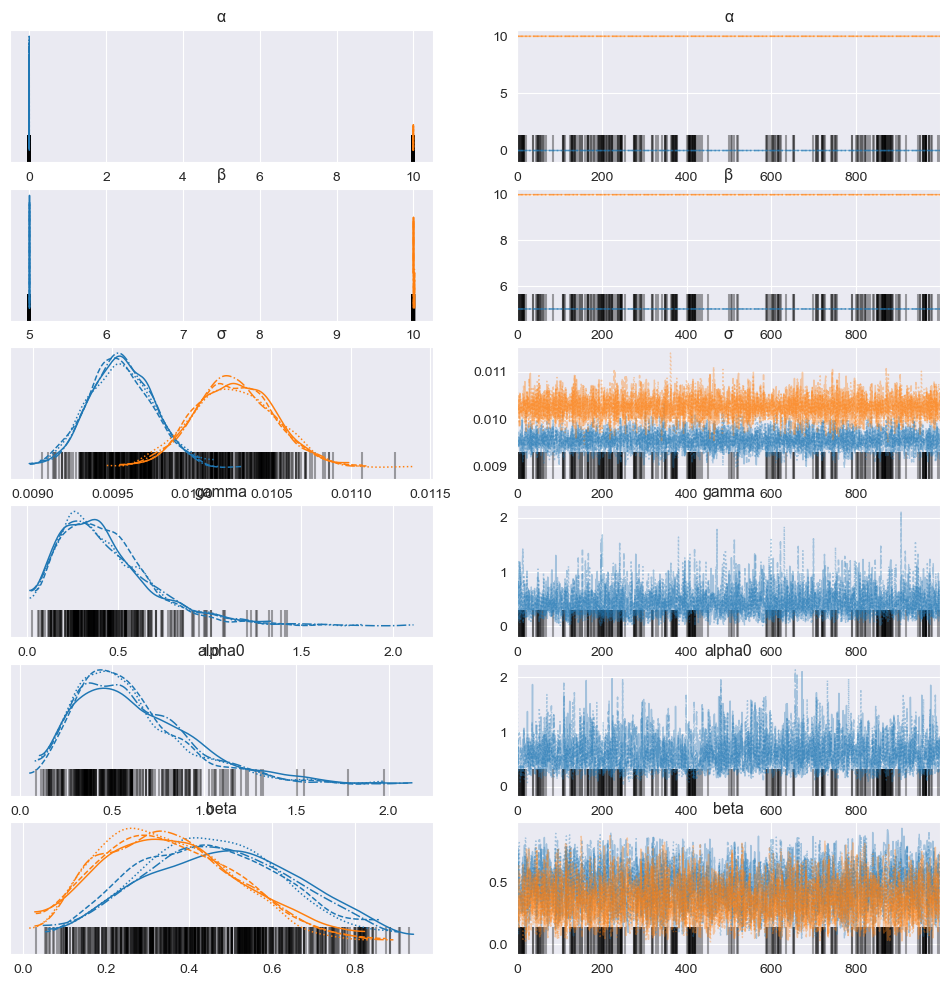

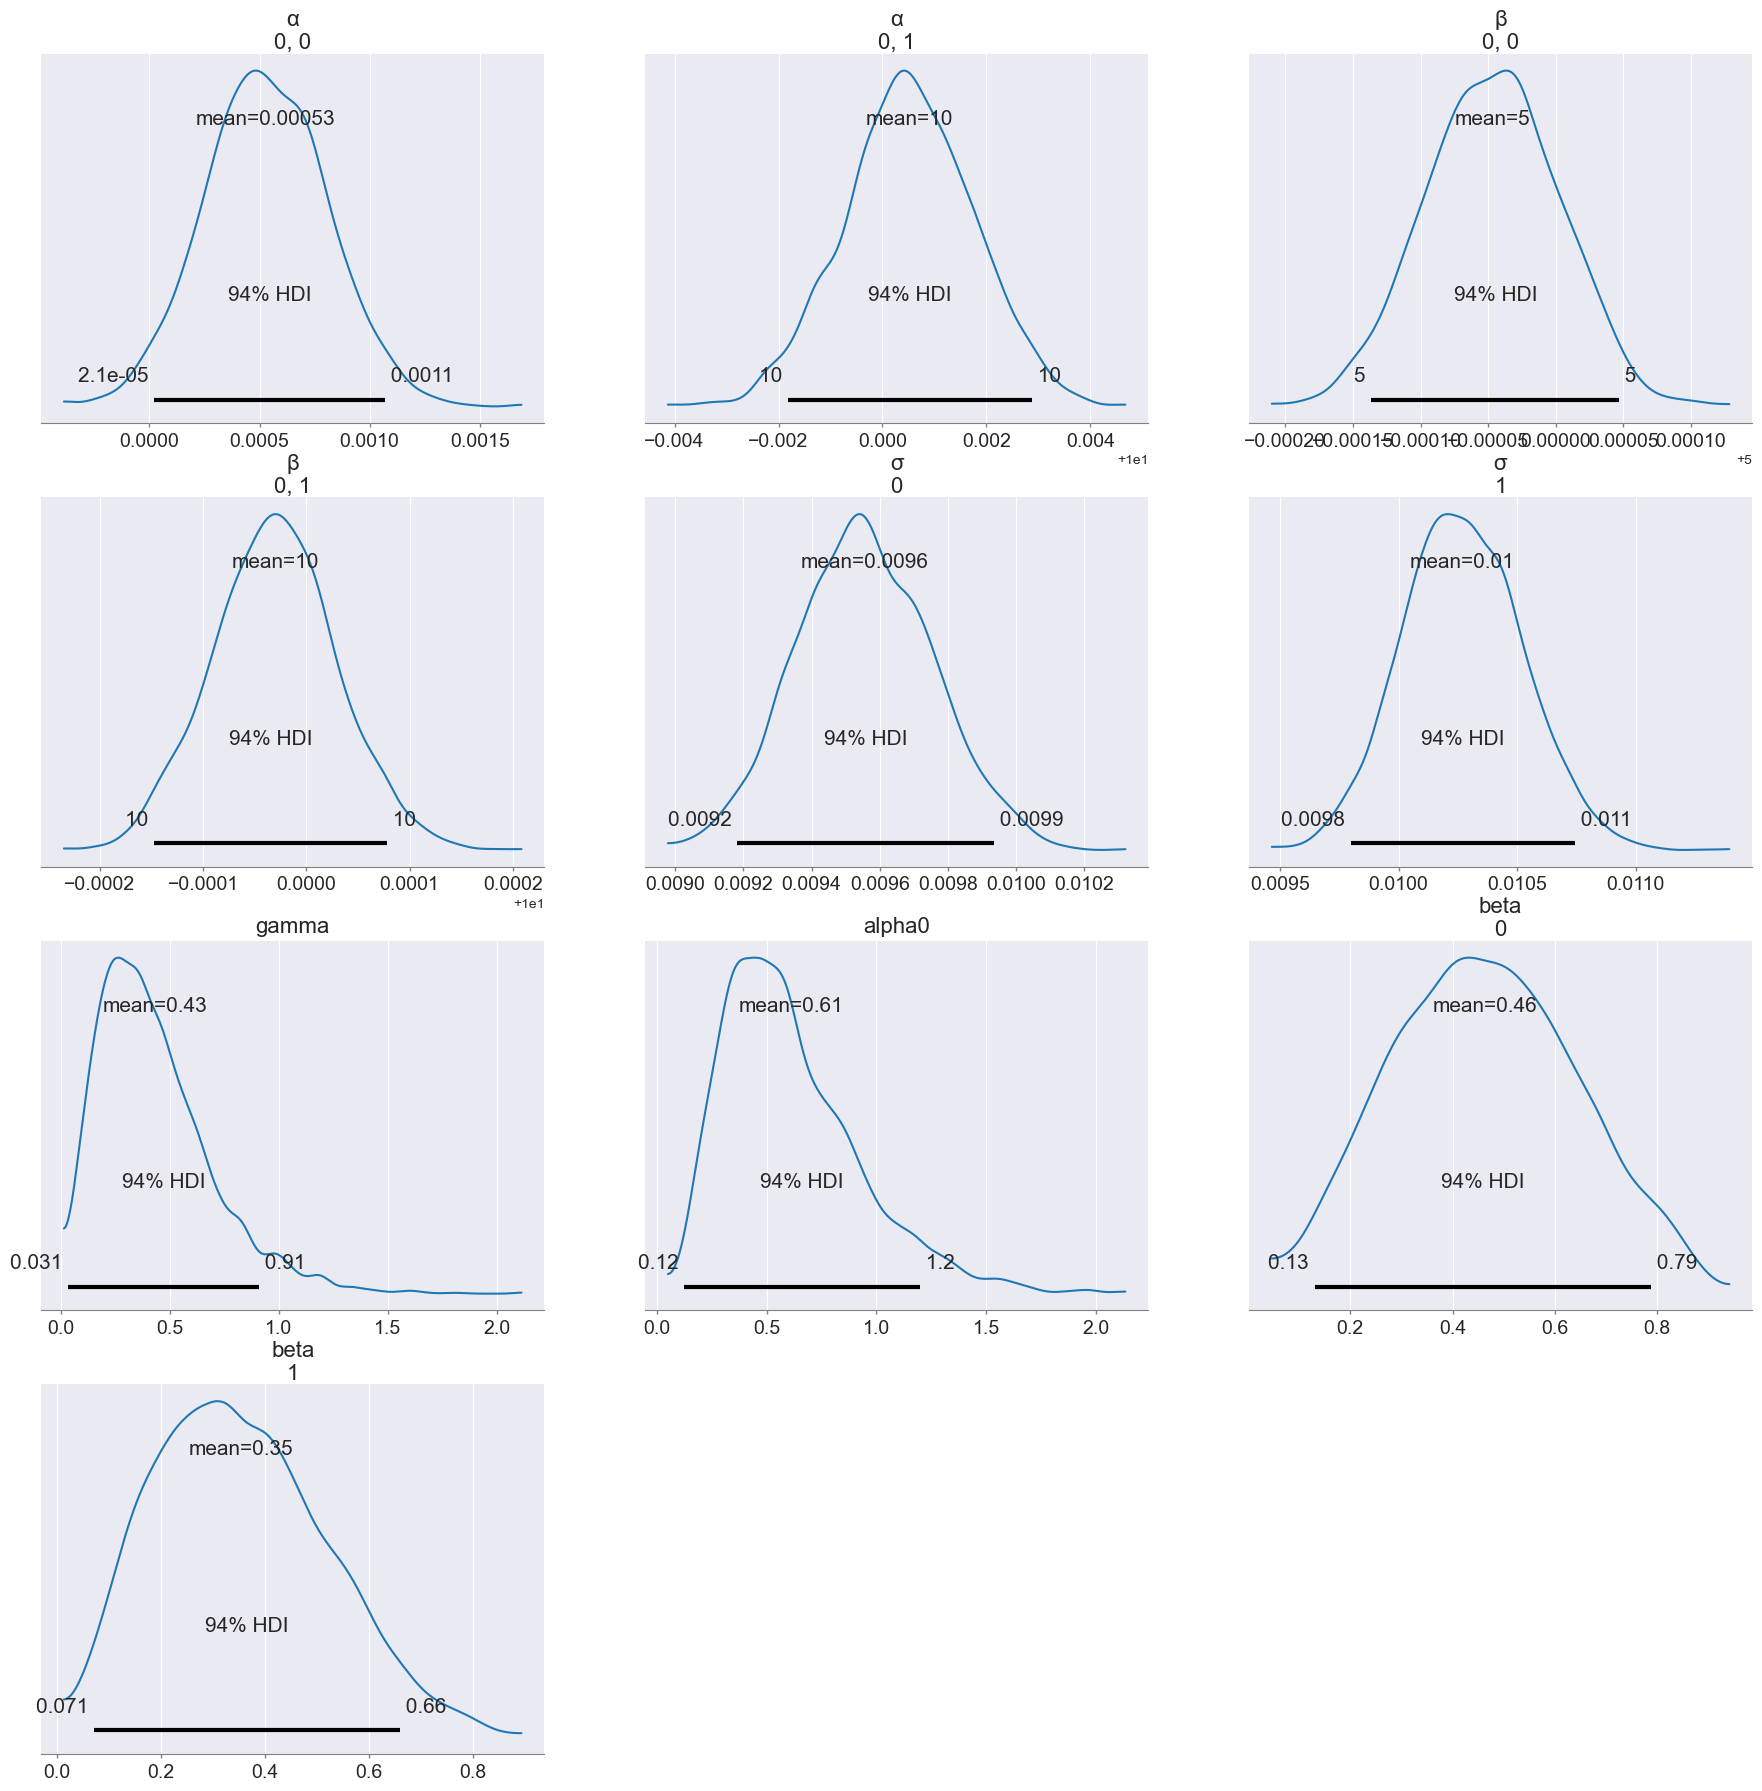

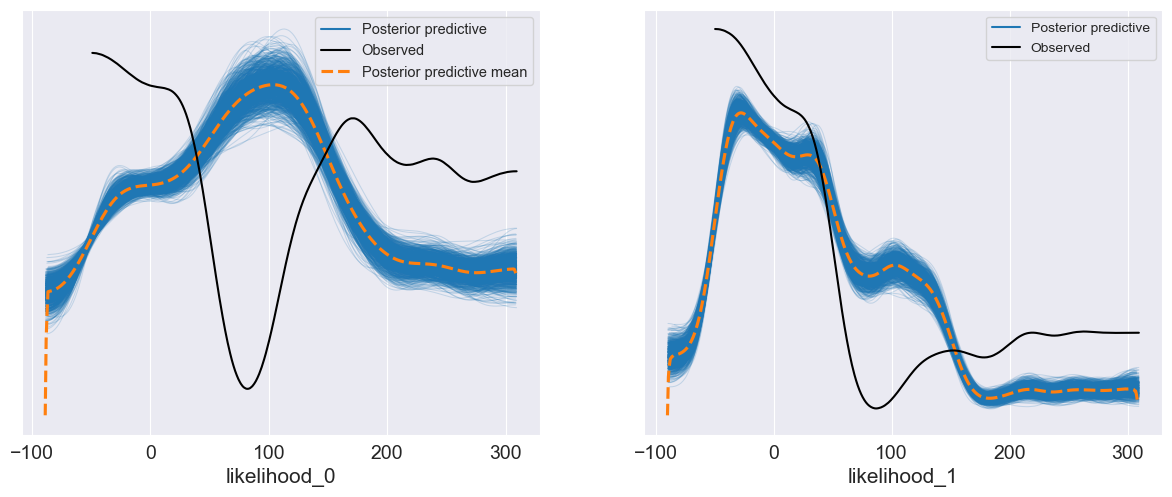

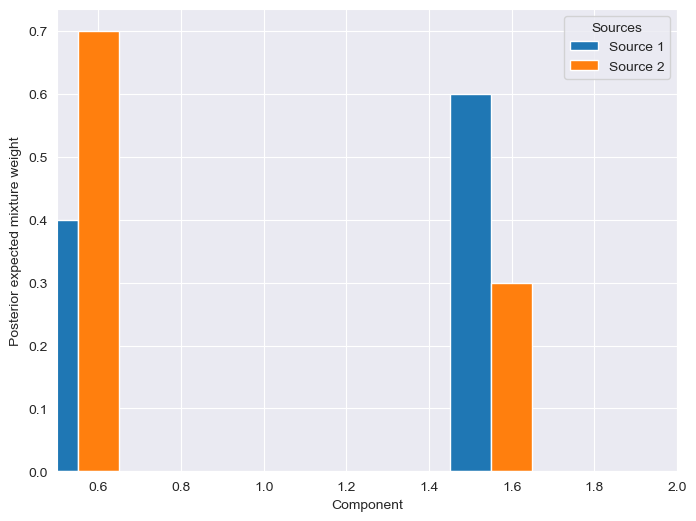

Running model for setting 2, total settings: 3
True proportion: [[0.4, 0.3, 0.3], [0.7, 0.2, 0.1]]
True regression parameters: [0, 10, -10], [5, 10, 20]
                mean       sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]        0.706    1.232  -0.013    3.138      0.612    0.468       7.0   
α[0, 1]        1.703    5.001  -4.389   10.006      2.487    1.905       5.0   
α[0, 2]        5.082    3.221   0.936   10.005      1.601    1.227       4.0   
β[0, 0]        6.949    3.396   4.999   13.437      1.689    1.293       7.0   
β[0, 1]        9.385    5.133   5.000   17.637      2.556    1.957       5.0   
β[0, 2]       10.847    3.992   6.590   17.587      1.987    1.521       5.0   
σ[0]          70.895  123.896   0.005  314.623     61.535   47.095       6.0   
σ[1]          31.044   53.779   0.009  126.190     26.773   20.498       7.0   
σ[2]         138.243  174.602   0.009  441.554     86.848   66.484       5.0   
gamma          0.658    0.212   0.283    0.984 

Sampling: [likelihood_0, likelihood_1]


Output()

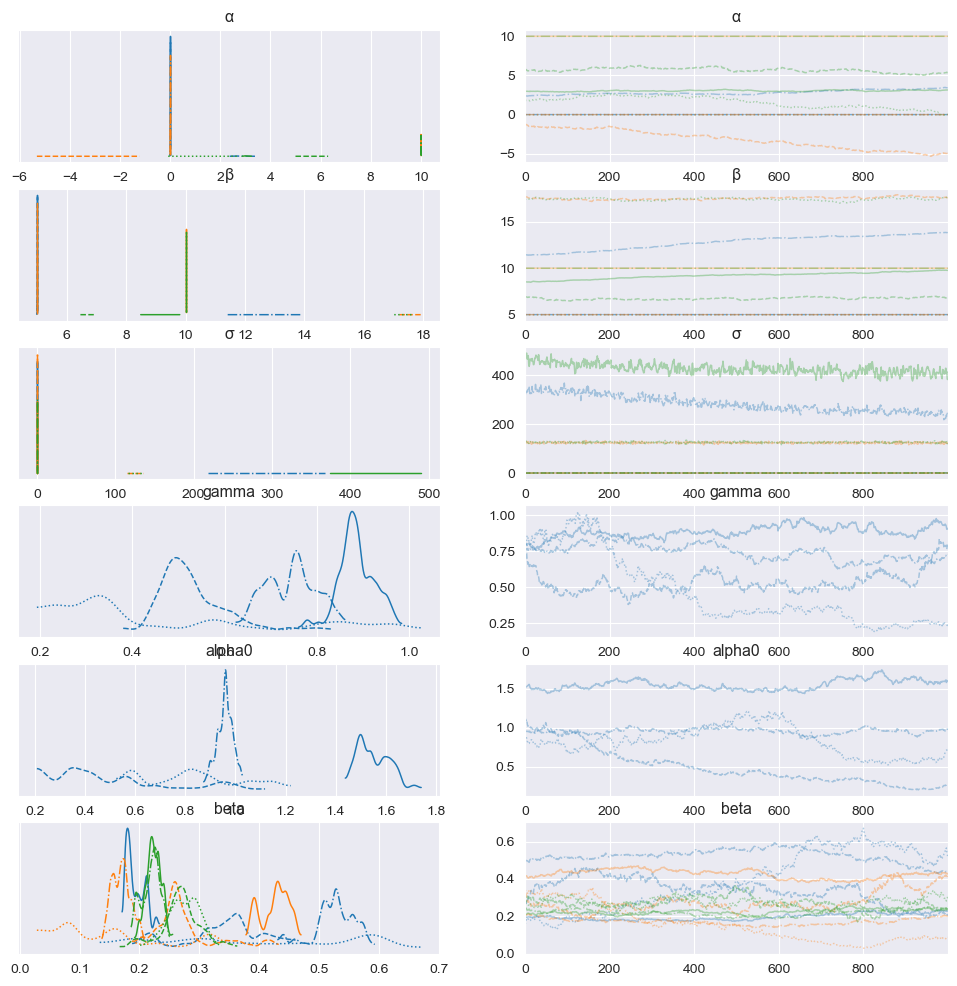

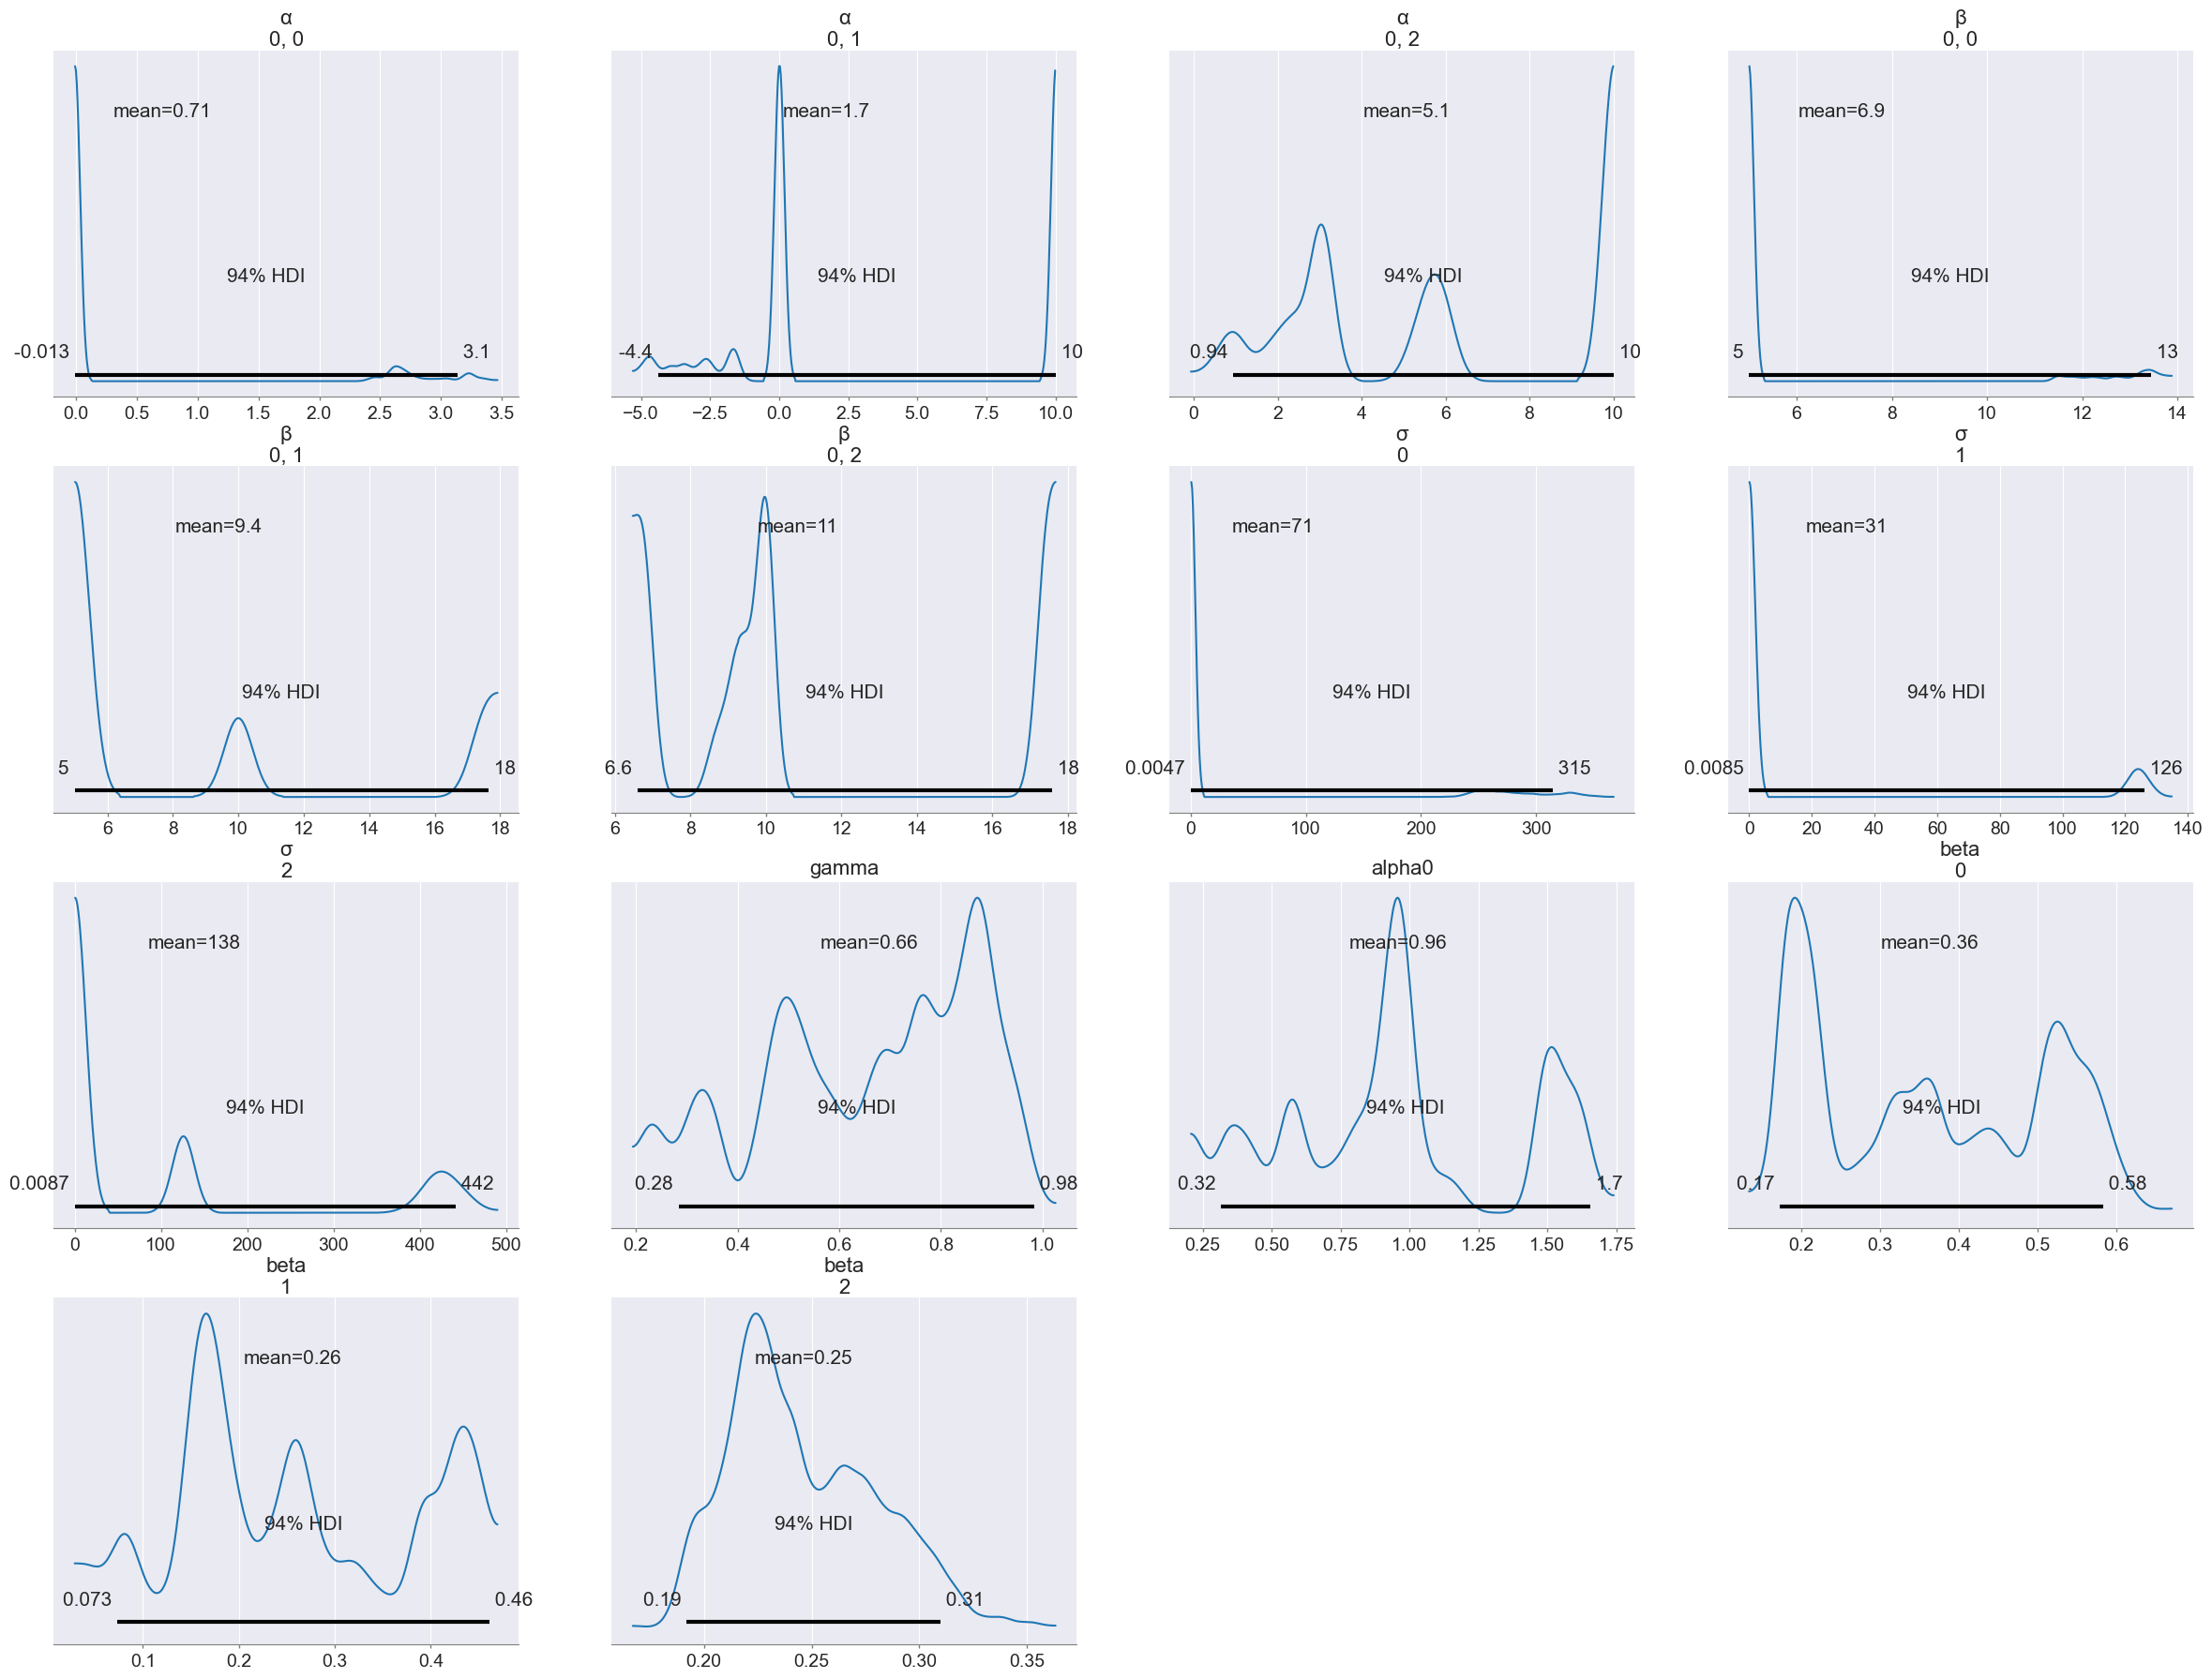

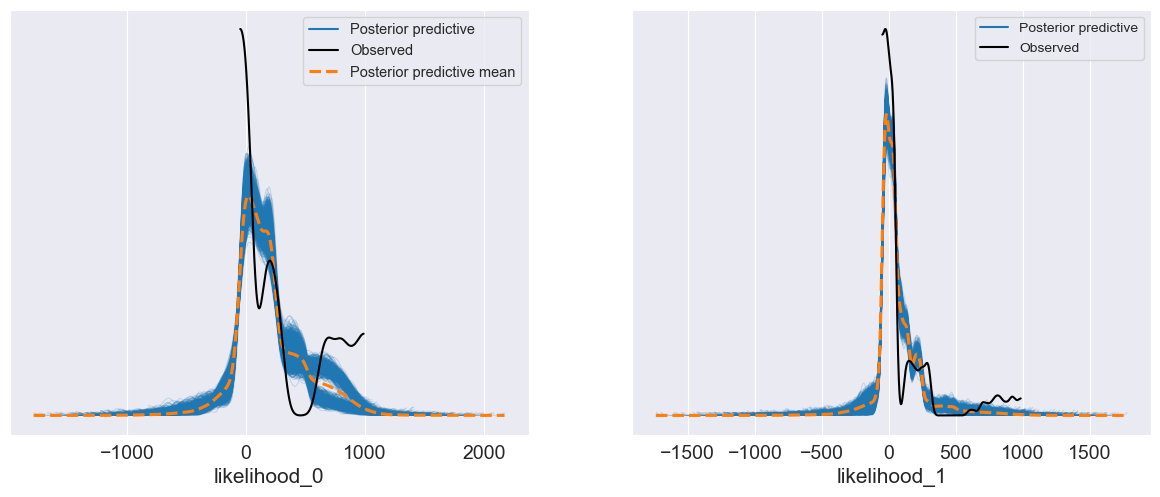

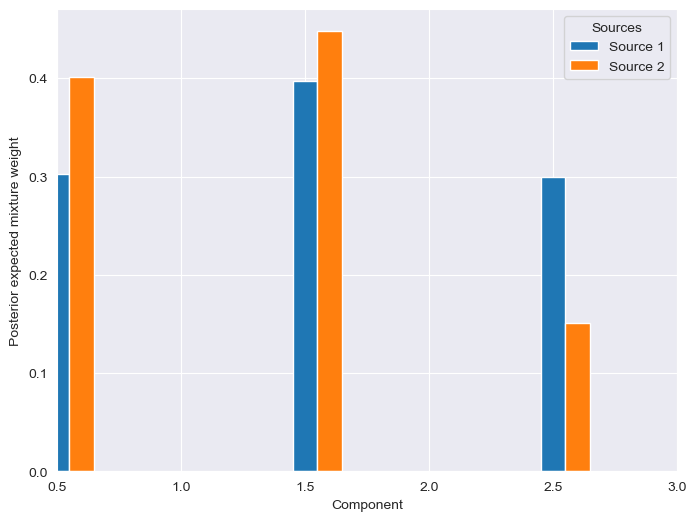

Running model for setting 3, total settings: 3
True proportion: [[0.3, 0.2, 0.4, 0.1], [0.7, 0.1, 0.1, 0.1]]
True regression parameters: [0, 10, -10, 20], [5, 10, 20, -5]
                mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[0, 0]        3.272    4.084   -0.005   10.003      2.034    1.557       5.0   
α[0, 1]       -2.500    4.331  -10.003    0.005      2.157    1.651       6.0   
α[0, 2]        0.433    1.374   -1.444    2.740      0.682    0.522       4.0   
α[0, 3]        5.000    4.999   -0.001   10.002      2.490    1.906       6.0   
β[0, 0]        4.947    3.613   -0.362   10.000      1.799    1.377       5.0   
β[0, 1]        8.750    6.496    4.999   20.000      3.235    2.477       7.0   
β[0, 2]        6.818    1.682    3.753    8.027      0.836    0.640       5.0   
β[0, 3]        7.500    2.500    4.999   10.000      1.245    0.953       6.0   
σ[0]          62.547  108.466    0.006  258.220     53.962   41.311       5.0   
σ[1]           0.01

Sampling: [likelihood_0, likelihood_1]


Output()

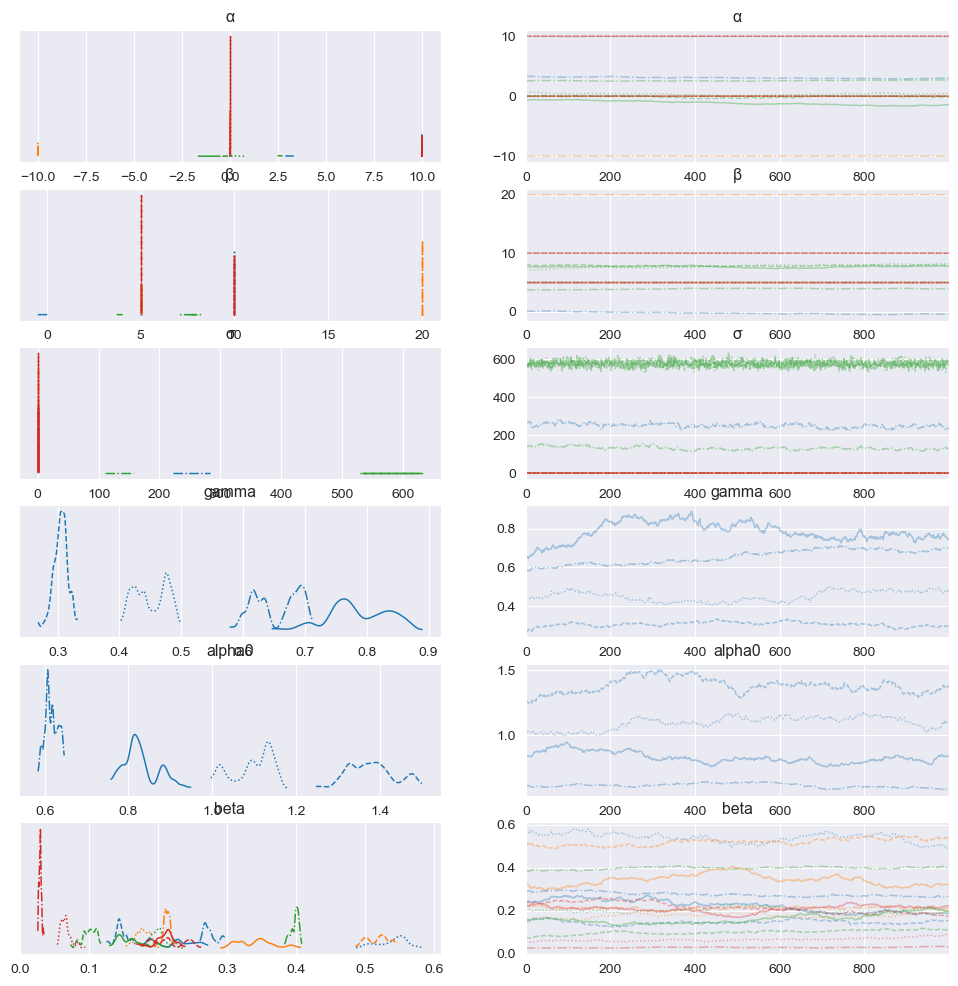

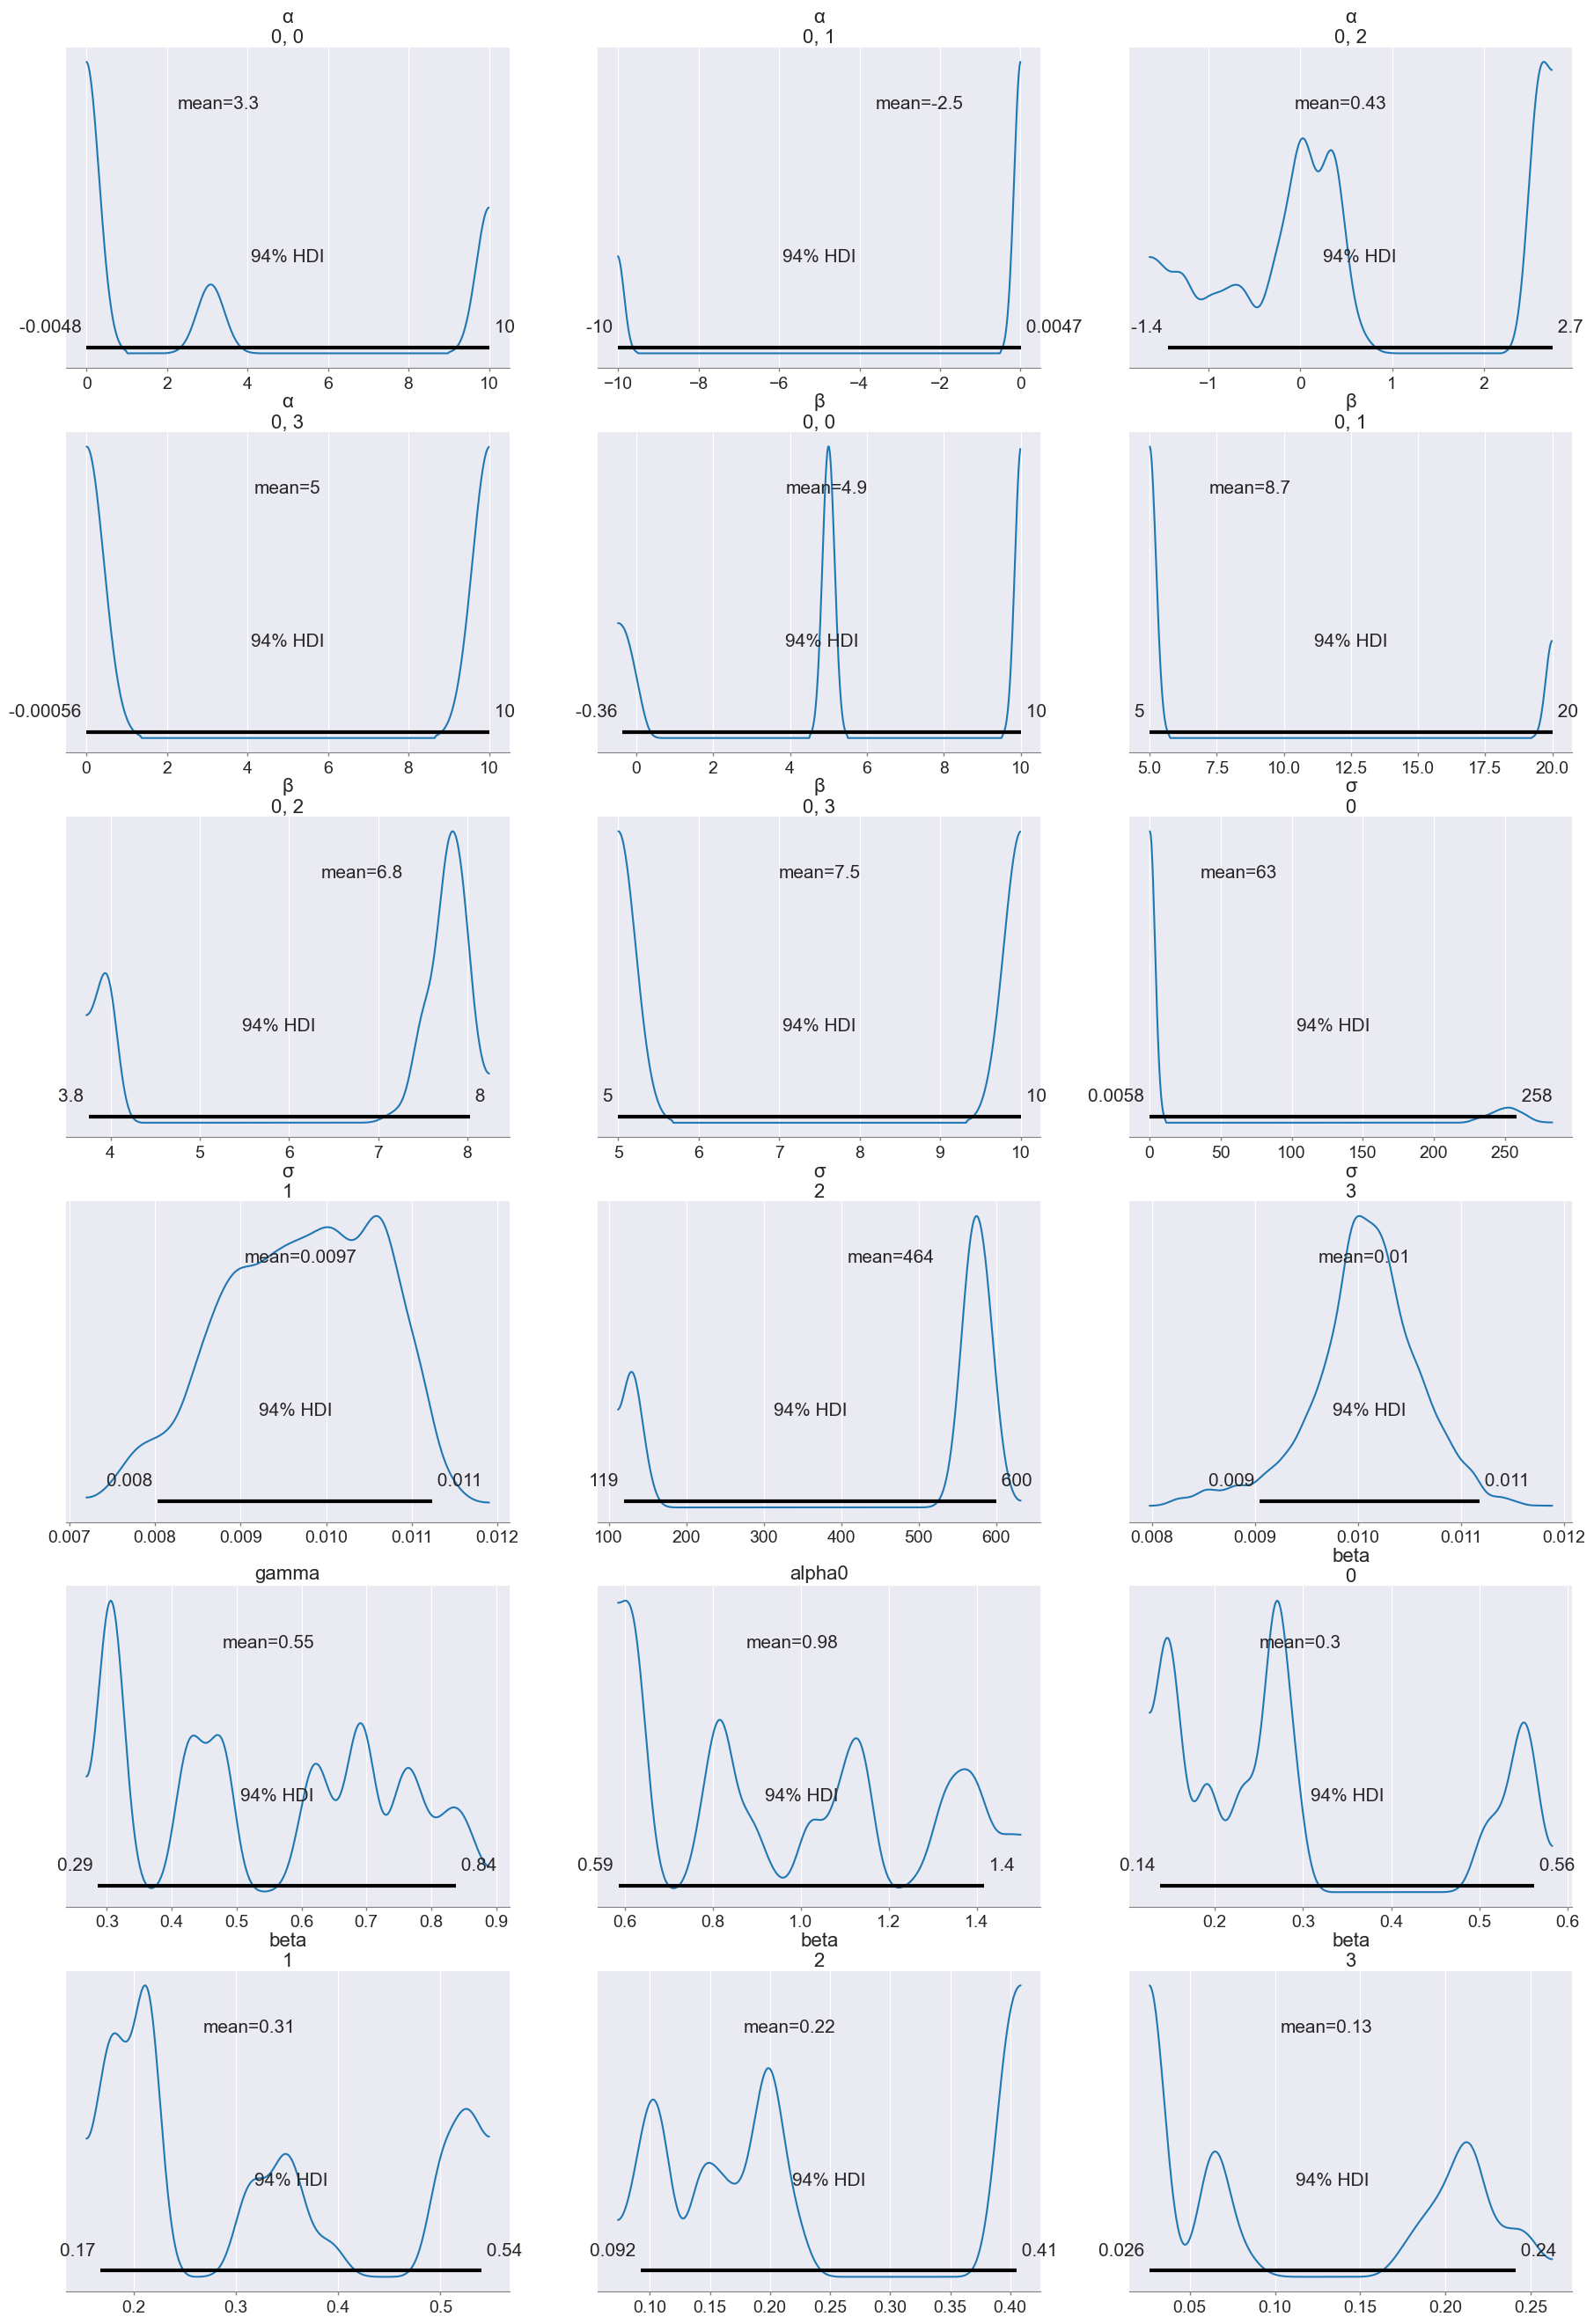

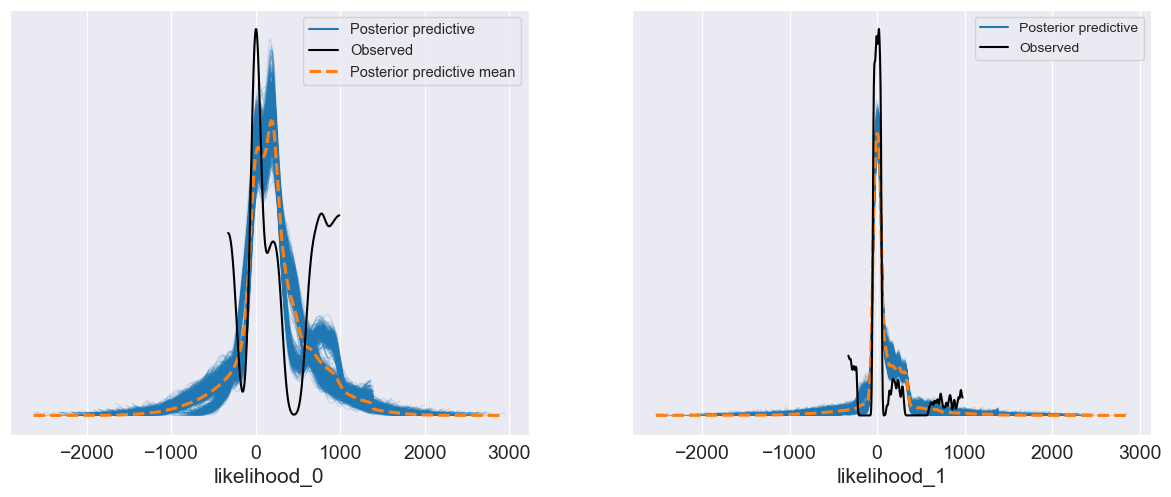

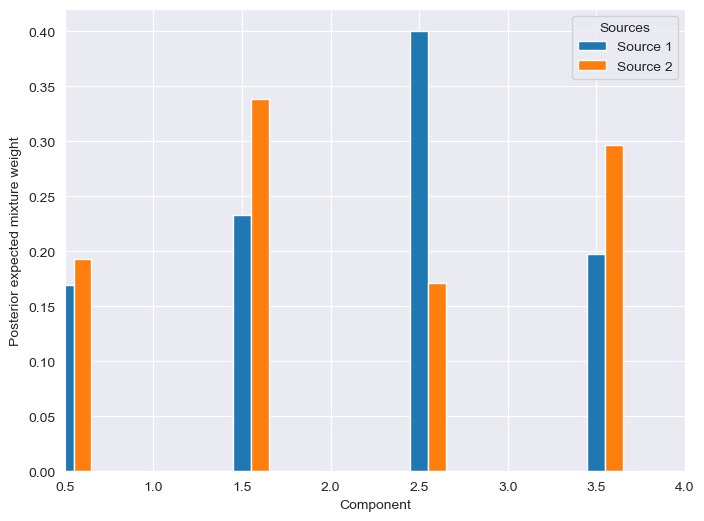

In [7]:
for i in range(N_settings):
    print(f"Running model for setting {i + 1}, total settings: {N_settings}")
    print(f"True proportion: {proportions[i]}")
    print(f"True regression parameters: {a[i]}, {b[i]}")
    summary_HDP(traces[i], models[i], N_sources=N_sources, k=ks[i])